code modified from: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/#setup

There are a lot of helpers that make using BERT easy with the Transformers library. I might want to also use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). 

I'll start with the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. 

# Sentiment Analysis with BERT

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn # optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Import the files that result from dataSplitBalance

underover_x_train = pd.read_csv("../dataBalSetsEcodes/underOver_x_train.csv", header=0, index_col=0)
underover_x_val = pd.read_csv("../dataBalSetsEcodes/underOver_x_val.csv", header=0, index_col=0)
underover_y_train = pd.read_csv("../dataBalancedSets/underOver_y_train.csv", header=0, index_col=0)
underover_y_val = pd.read_csv("../dataBalancedSets/underOver_y_val.csv", header=0, index_col=0)

# And the test dataset
x_test = pd.read_csv("../dataBalSetsEcodes/x_test.csv", header=0, index_col=0)
y_test = pd.read_csv("../dataBalancedSets/y_test_sent.csv", header=0, index_col=0)

print("Undersampled")
print("x-train:", underover_x_train.shape, "x-val:", underover_x_val.shape, "y-train:", underover_y_train.shape, "y-val:", underover_y_val.shape)
print("TEST DATA")
print("x-TEST:", x_test.shape, "y-TEST:", y_test.shape)


Undersampled
x-train: (982, 3) x-val: (247, 3) y-train: (982, 5) y-val: (247, 5)
TEST DATA
x-TEST: (182, 3) y-TEST: (182, 5)


In [4]:

!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
3964 MiB


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.



In [5]:
# DATASET = "../data/tweets_clean.csv"  # this is the full, labeled dataset for training.
X_TRAIN = underover_x_train
Y_TRAIN = underover_y_train
X_VAL = underover_x_val
Y_VAL = underover_y_val
X_TEST = x_test
Y_TEST = y_test
class_names = ['negative', 'neutral', 'positive']

CONTENT_COL = "ContentClean"
SCORE_COL = "y_sent"

EPOCHS = 10
BATCH_SIZE = 8
MAX_LEN = 150
TRAIN_PERCENT = .80

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


# original example: Initialcores are 1,2,3,4,5

In [6]:
print(list(X_TRAIN.columns))
print(list(Y_TRAIN.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


In [8]:
# Put the dfs together in the format needed for this notebook
frames1 = [X_TRAIN, Y_TRAIN]
df_train = pd.concat(frames1, axis=1, ignore_index=True) #comb horiz
df_train.columns = ['id_stable', 'Date', 'ContentClean','trash', 'label_sent', 'y_sent', 'label_stance', 'y_stance']
df_train.drop(["trash", 'label_sent', 'label_stance', 'y_stance'], axis = 1, inplace=True)

frames2 = [X_VAL, Y_VAL]
df_val = pd.concat(frames2, axis=1, ignore_index=True)
df_val.columns = ['id_stable', 'Date', 'ContentClean','trash', 'label_sent', 'y_sent', 'label_stance', 'y_stance']
df_val.drop(["trash", 'label_sent', 'label_stance', 'y_stance'], axis = 1, inplace=True)


frames3 = [X_TEST, Y_TEST]
df_test = pd.concat(frames3, axis=1, ignore_index=True)
df_test.columns = ['id_stable', 'Date', 'ContentClean','trash', 'label_sent', 'y_sent', 'label_stance', 'y_stance']
df_test.drop(["trash", 'label_sent', 'label_stance', 'y_stance'], axis = 1, inplace=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(982, 4)
(247, 4)
(182, 4)


## Data Exploration

In [9]:
df_train.head()

,id_stable,Date,ContentClean,y_sent
0,22583,2022-01-27 21:53:05+00:00,Thousands of Afghan evacuees have been welcome...,2
1,141728,2021-08-19 09:18:21+00:00,Bespoke resettlement route for Afghan refugees,1
2,11317,2022-03-08 05:06:09+00:00,Instead the Afghan Resettlement project is sta...,1
3,177593,2021-08-08 21:04:20+00:00,"Taliban will kill us, warn over 100 former Afg...",0
4,91649,2021-09-03 14:31:58+00:00,Unfortunately it took Canada until Aug 31 to j...,0


In [10]:
df_val.head()

,id_stable,Date,ContentClean,y_sent
0,59962,2021-10-02 16:41:49+00:00,Never Trumpers impeached Trump twice. Biden ab...,0
1,131370,2021-08-21 15:00:03+00:00,They were vetted. Elsewhere. In Afghanistan. T...,0
2,149133,2021-08-18 08:12:19+00:00,"20 yrs ago, Democrats tricked Bush into invadi...",0
3,43446,2021-11-16 23:10:02+00:00,TY for participating in the quarter drive & gi...,2
4,24629,2022-01-20 14:25:55+00:00,as a poor Afghan Refugee after passing 8years ...,0


In [11]:
df_test.head()

,id_stable,Date,ContentClean,y_sent
1146,99980,2021-08-31 07:32:17+00:00,Here are his views...he was responding to a pa...,1
866,131423,2021-08-21 14:43:51+00:00,Are all of them translators or US allies from ...,1
780,136483,2021-08-20 10:30:00+00:00,The UN #refugee agency UNHCR says most #Afghan...,0
370,13610,2022-03-01 11:40:44+00:00,Putin still has the right to invade. NATO didn...,0
189,36057,2021-12-08 13:59:16+00:00,"100 Women: The former child refugee, now lawye...",2


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982 entries, 0 to 981
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_stable     982 non-null    int64 
 1   Date          982 non-null    object
 2   ContentClean  982 non-null    object
 3   y_sent        982 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 38.4+ KB


No missing values in the score and review texts. 

Do we have class imbalance?

c:\Users\rnocker\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


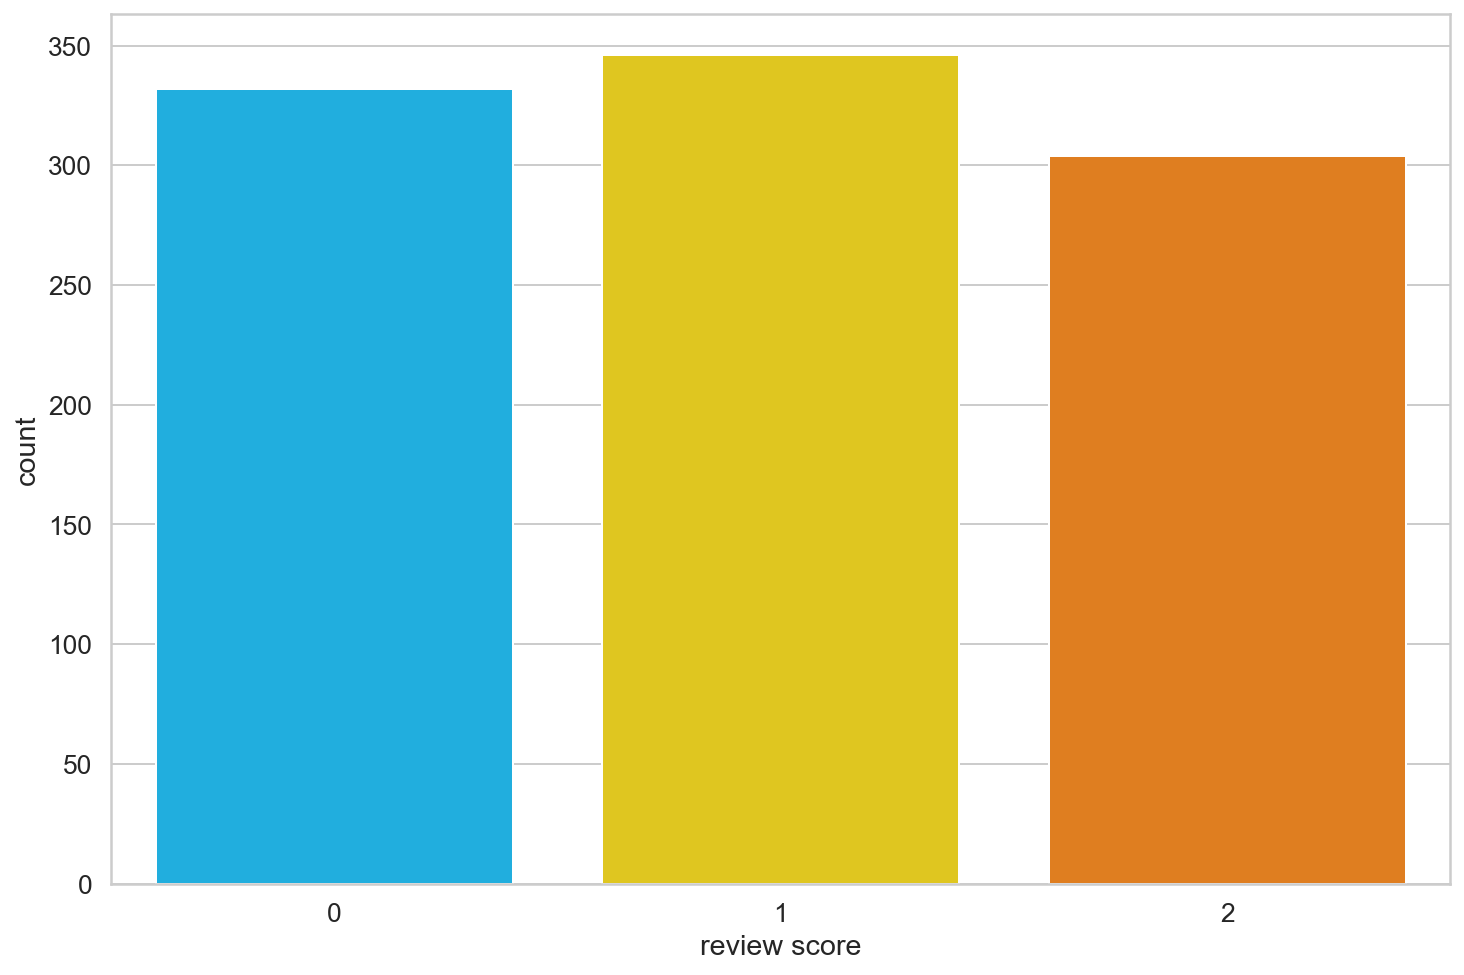

In [13]:
sns.countplot(df_train[SCORE_COL])
plt.xlabel('review score');

## Data Preprocessing

Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [15]:
token_lens = []

for txt in df_train[CONTENT_COL]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

c:\Users\rnocker\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


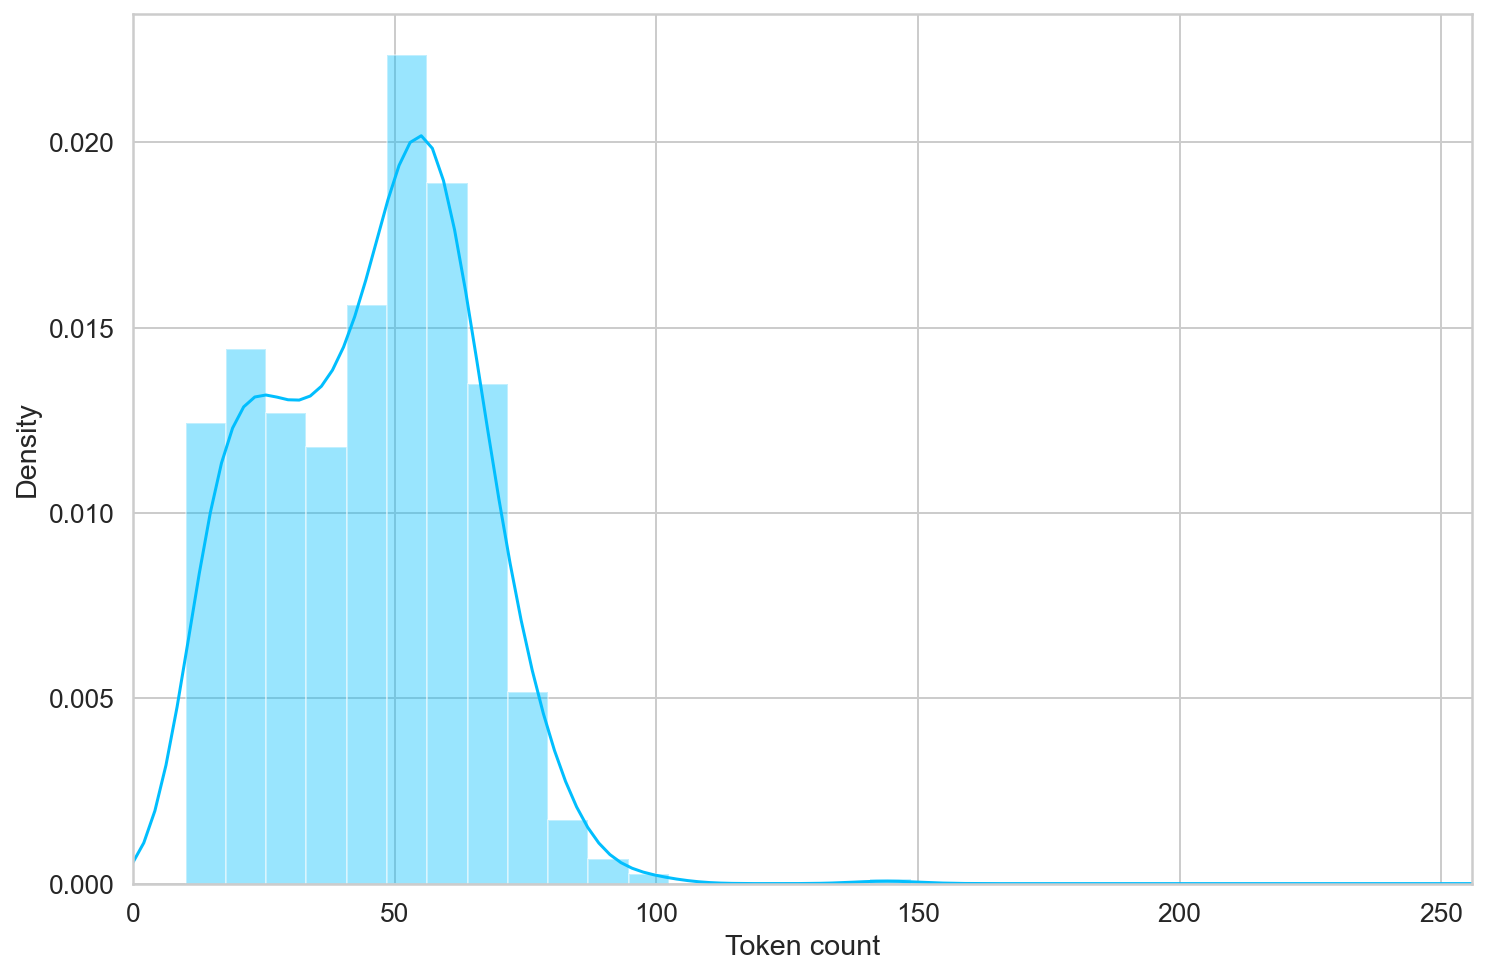

In [16]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain fewer than 100 tokens, but we'll be on the safe side and choose a maximum length of 150 (set above, as hyperparameter).

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [17]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [18]:
df_train.shape, df_val.shape, df_test.shape

((982, 4), (247, 4), (182, 4))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df[CONTENT_COL].to_numpy(),
    targets=df[SCORE_COL].to_numpy(),  
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [20]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# df_full = []
# full_data_loader = create_data_loader(df_full, tokenizer, MAX_LEN, BATCH_SIZE)


## Sentiment Classification with BERT and Hugging Face

Let's load the model:

In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can use all of this knowledge to create a classifier that uses the BERT model:

In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [23]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Let's continue with writing a helper function for training our model for one epoch:

In [25]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [27]:
%%time
# around 11 min per run

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

# if val_acc > best_accuracy:
    # torch.save(model.bert.state_dict(), 'best_model_state.bin')
    # model.bert.config.to_json_file('best_model_config.json')  #GINA2
    # tokenizer.save_vocabulary('./') #GINA2
    # best_accuracy = val_acc

Epoch 1/10
----------


c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.9420123976178285 accuracy 0.5193482688391038
Val   loss 1.9734111370578888 accuracy 0.4534412955465587

Epoch 2/10
----------
Train loss 0.8291996068707327 accuracy 0.6558044806517311
Val   loss 2.8212401198163146 accuracy 0.4777327935222672

Epoch 3/10
----------
Train loss 0.8159701893393828 accuracy 0.6914460285132382
Val   loss 3.0037937178126266 accuracy 0.4534412955465587

Epoch 4/10
----------
Train loss 0.6434499673825514 accuracy 0.7973523421588594
Val   loss 2.562797038380297 accuracy 0.5425101214574899

Epoch 5/10
----------
Train loss 0.5808859497641887 accuracy 0.8431771894093686
Val   loss 2.0349361742696455 accuracy 0.6356275303643725

Epoch 6/10
----------
Train loss 0.49144900070760794 accuracy 0.8818737270875763
Val   loss 1.7290622603388563 accuracy 0.6234817813765182

Epoch 7/10
----------
Train loss 0.391404407999925 accuracy 0.8900203665987779
Val   loss 2.0530881468326814 accuracy 0.6153846153846154

Epoch 8/10
----------
Train loss 0.401653448657352

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

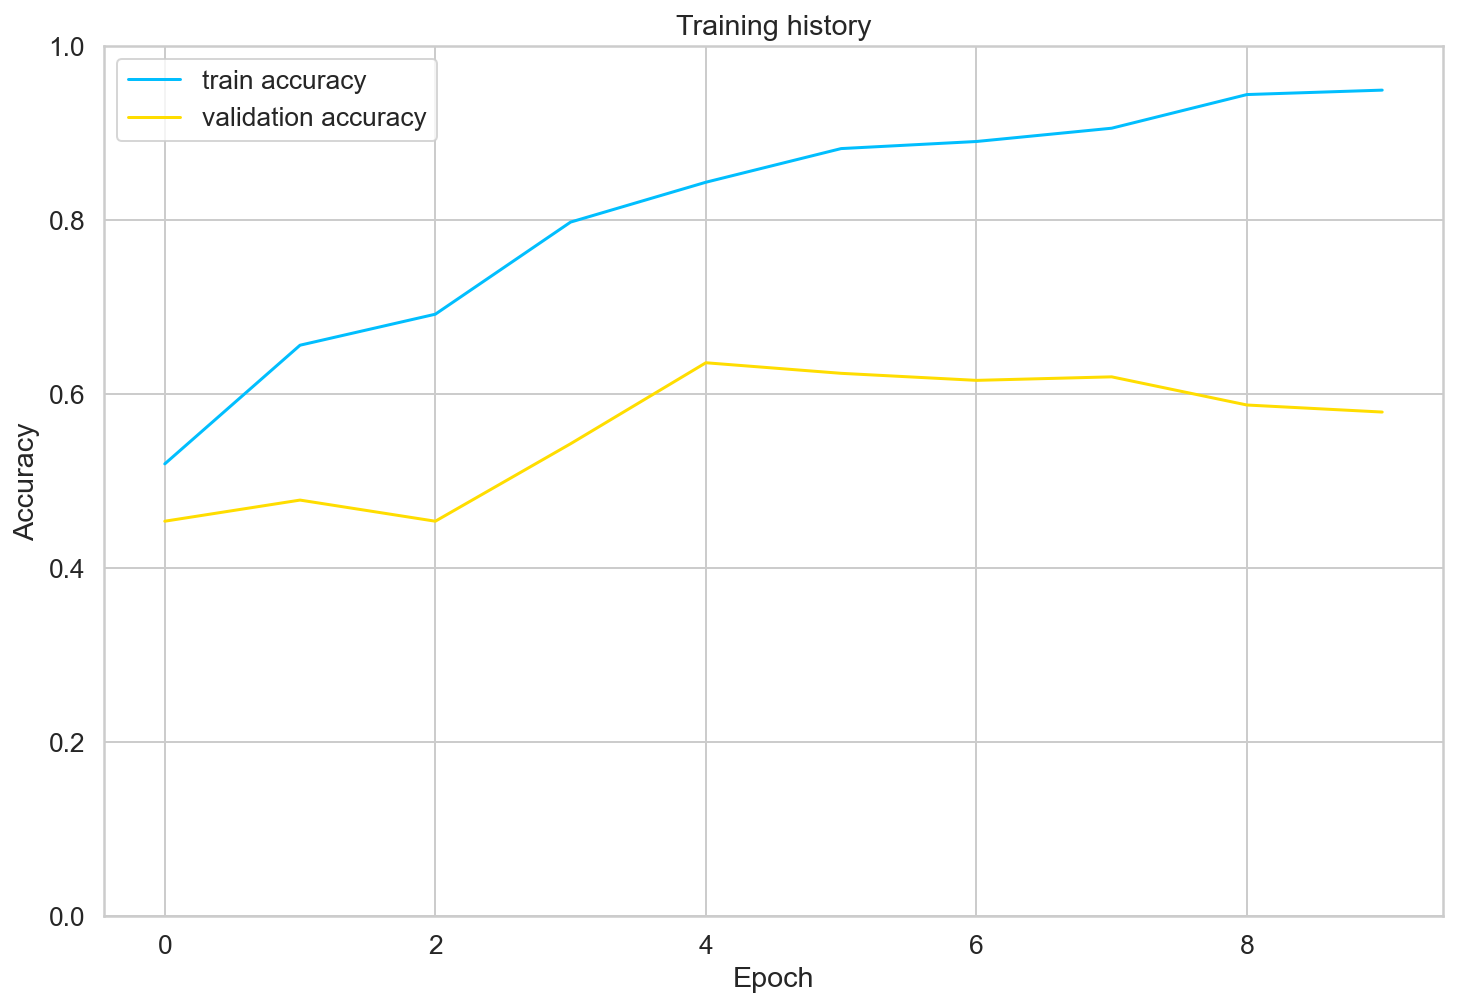

In [28]:
plt.plot(list(map(lambda x:x.item(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.item(), history['val_acc'])), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.


In [29]:
# # class_names = ['negative', 'neutral', 'positive']
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [30]:
device

device(type='cuda', index=0)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.7472527472527473

We'll define a helper function to get the predictions from our model:

In [32]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Let's have a look at the classification report

In [34]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85       110
     neutral       0.59      0.58      0.59        38
    positive       0.67      0.47      0.55        34

    accuracy                           0.75       182
   macro avg       0.69      0.65      0.66       182
weighted avg       0.74      0.75      0.74       182



Looks like it is really hard to classify neutral and positive tweets. 

We'll continue with the confusion matrix of the test data:

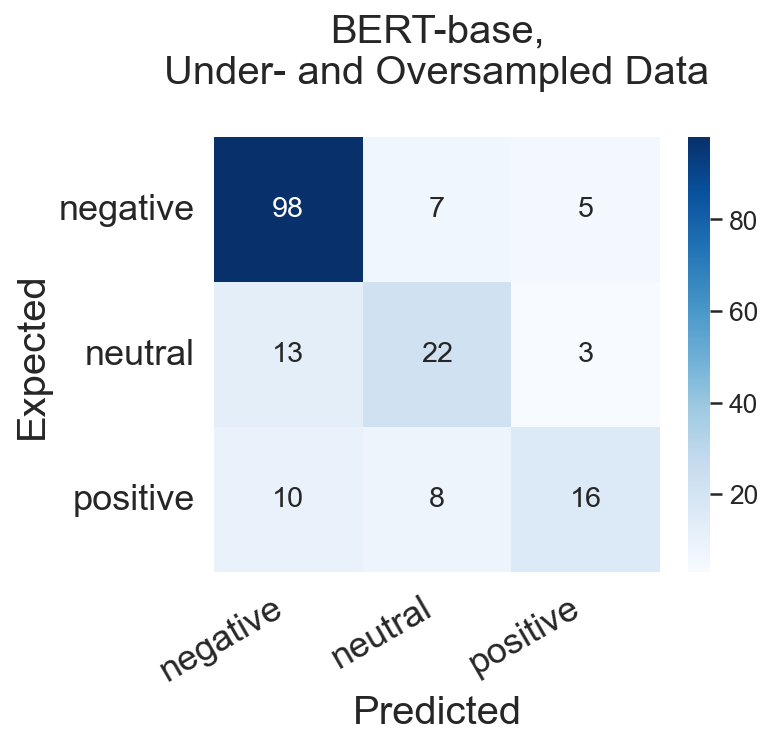

In [37]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=18)
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=18)
  plt.title("BERT-base,\nUnder- and Oversampled Data\n", fontsize=20)
  plt.ylabel('Expected', fontsize=20)
  plt.xlabel('Predicted', fontsize=20);
  
fig, ax = plt.subplots(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [36]:
y_pred_l = y_pred.tolist()
y_test_l = y_test.tolist()

print(len(y_pred_l))
print(y_pred_l.count(0), y_pred_l.count(1), y_pred_l.count(2))
print()
print(len(y_test_l))
print(y_test_l.count(0), y_test_l.count(1), y_test_l.count(2))


182
121 37 24

182
110 38 34


This confirms that our model is having difficulty classifying neutral and positive reviews. It mistakes those for the other classes at a roughly equal frequency.

That's a good overview of the performance of our model.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)